In [1]:
import pandas as pd
import numpy as np
import csv

from time import perf_counter
from utils import get_genome_examples, get_vocab
%load_ext autoreload
%autoreload 2

In [2]:
df = get_genome_examples(directory_name = 'trainingdata', num_samples = 200_000, delay_start = 0)
dataset = df

Created set with 1200000 samples


In [3]:
# there is a class imbalance (there are more than 3m human examples,
# so max is 1.3m which is the max for Rhinovirus)
print(dataset.groupby('label').count())
dataset = dataset.sample(frac=1)

                 genome
label                  
Coronaviridae    200000
Human            200000
Influenza        200000
Metapneumovirus  200000
Rhinovirus       200000
Sars_Cov-2       200000


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def count_vectorizer(dataset):
           
    # combined the kmer and count vectorizer into 1 function
    cv = CountVectorizer(ngram_range=(5, 5), vocabulary=get_vocab(5),
                         tokenizer=lambda x: list(x), lowercase=False)  
    
    tic = perf_counter()
    vectorized_array = cv.fit_transform(dataset)
    print(f"Counter Vectorizer took: {perf_counter() - tic:4.1f}[s]")
    
    return vectorized_array, cv

# created a function so you can use it later
vectorized_array, cv = count_vectorizer(dataset['genome'])

Counter Vectorizer took: 104.4[s]


In [5]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=300)
#vectorized_array_new = pca.fit_transform(vectorized_array.toarray())

In [6]:
#sum(pca.explained_variance_ratio_ * 100 )

In [7]:
#from sklearn.decomposition import TruncatedSVD
#svd = TruncatedSVD(n_components=400, n_iter=7, random_state=42)
#tic = perf_counter()
#vectorized_array_new = svd.fit_transform(vectorized_array.toarray())
#print(f"svd took: {perf_counter() - tic:4.1f}[s]")

In [8]:
#sum(svd.explained_variance_ratio_ * 100)

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MaxAbsScaler

# scale the features
scaler = MaxAbsScaler()  # same as MinMax but works for sparse datasets
X_features = scaler.fit_transform(vectorized_array)

# encode the labels
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(dataset["label"])

In [10]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X_features)

5

In [11]:
KFold(n_splits=5, random_state=None, shuffle=False)

KFold(n_splits=5, random_state=None, shuffle=False)

In [12]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix, classification_report
#for train_index, test_index in kf.split(X_features):
    #print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X_features[train_index], X_features[test_index]
#    y_train, y_test = labels[train_index], labels[test_index]
#    params=dict(n_jobs=-1, class_weight="balanced", n_estimators=50, verbose=1)
#    classifier = RandomForestClassifier(**params)
#    tic = perf_counter()
#    classifier.fit(X_train, y_train)
#    print(f"Random Forest trained took: {perf_counter() - tic:.4f}[s]")
#    tic = perf_counter()
#    y_pred = classifier.predict(X_test)
#    print(f"Random Forest test took: {perf_counter() - tic:.4f}[s]")
#    print(classification_report(y_test, y_pred))

In [13]:
from sklearn.model_selection import train_test_split

# (20% train, 80% test); results showed you only needed 100-200k to train, so made test 80%
#X_train, X_test, y_train, y_test = train_test_split(X_features, labels, 
 #                                                   test_size=0.8, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X_features, labels,
    test_size=0.84, random_state = 8)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
   # test_size=0.8, random_state= 8) 


In [14]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)

(192000, 1024)
(1008000, 1024)


In [15]:
from sklearn.ensemble import RandomForestClassifier

params=dict(n_jobs=-1, class_weight="balanced", n_estimators=50, verbose=1)

classifier = RandomForestClassifier(**params)

tic = perf_counter()
classifier.fit(X_train, y_train)
print(f"Random Forest took: {perf_counter() - tic:.4f}[s]")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min


Random Forest took: 182.1152[s]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


In [16]:
#from sklearn.neural_network import MLPClassifier
#params = dict(learning_rate_init=5e-3, hidden_layer_sizes=[64, 32],
#              verbose=True, early_stopping=True,  n_iter_no_change=5) #validation_fraction=0.2
#classifier =  MLPClassifier(**params)

#tic = perf_counter()
#classifier.fit(X_train, y_train)
#print(f"MLP took: {perf_counter() - tic:.4f}[s]")

In [17]:
#from catboost import CatBoostClassifier
#classifier = CatBoostClassifier(learning_rate=5e-3,max_depth=5)
#tic = perf_counter()
#classifier.fit(X_train, y_train)
#print(f"CatBoost took: {perf_counter() - tic:.4f}[s]")

In [18]:
#from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(weights="uniform",n_jobs=-1)
#tic = perf_counter()
#classifier.fit(X_train, y_train)
#print(f"KNeighborsClassifier took: {perf_counter() - tic:.4f}[s]")

In [19]:
#from sklearn.ensemble import ExtraTreesClassifier
#classifier = ExtraTreesClassifier(class_weight="balanced",n_estimators=50, verbose=1)
#tic = perf_counter()
#classifier.fit(X_train, y_train)
#print(f"ExtraTreesClassifier took: {perf_counter() - tic:.4f}[s]")

In [20]:
tic = perf_counter()
y_pred = classifier.predict(X_test)
print(f"Random Forest took: {perf_counter() - tic:.4f}[s]")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s


Random Forest took: 8.4476[s]


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    5.4s finished


In [21]:
import pickle
s = pickle.dumps(classifier)
clf2 = pickle.loads(s)


In [22]:
from sklearn.metrics import confusion_matrix, classification_report # (size=3,(3,3))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    167974
           1       0.99      0.98      0.99    168057
           2       1.00      1.00      1.00    167757
           3       1.00      1.00      1.00    168282
           4       0.99      1.00      0.99    167927
           5       1.00      1.00      1.00    168003

    accuracy                           1.00   1008000
   macro avg       1.00      1.00      1.00   1008000
weighted avg       1.00      1.00      1.00   1008000



In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[167254,    657,      0,      0,     63,      0],
       [  1205, 165332,      0,      0,   1520,      0],
       [    19,    516, 167207,      0,     15,      0],
       [     0,      0,      0, 168282,      0,      0],
       [     7,    192,      0,      0, 167728,      0],
       [     0,      0,      0,      0,      0, 168003]])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    5.2s finished


<Figure size 720x720 with 0 Axes>

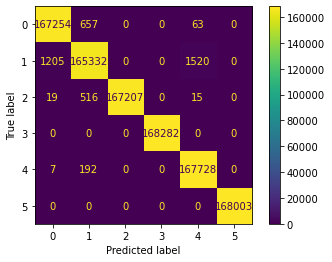

<ipython-input-24-e892a28143d7>:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figure.png", dpi=150, bbox_inches='tight',cmap="GnBu")


<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()
plt.savefig("figure.png", dpi=150, bbox_inches='tight',cmap="GnBu")

In [25]:
#y_pred_val = classifier.predict(X_val)

In [26]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_val, y_pred_val)

In [27]:
#from sklearn.metrics import confusion_matrix,classification_report # (size=3,(3,3))
#print(classification_report(y_val, y_pred_val))